<a href="https://colab.research.google.com/github/Macleyn/ML/blob/main/%D0%A6%D0%9A_%D0%9C%D0%A4%D0%A2%D0%98/boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
!pip install catboost

In [65]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [66]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
df = df.drop(columns=['customerID'])

In [68]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['Churn'], random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

binary_cols = X_train.select_dtypes(include=['object']).columns[X_train.select_dtypes(include=['object']).nunique() == 2]
categorical_cols = X_train.select_dtypes(include=['object']).columns[X_train.select_dtypes(include=['object']).nunique() > 2]

In [69]:
from catboost import CatBoostClassifier
cat_features = np.concatenate([categorical_cols, binary_cols])
catboost = CatBoostClassifier(random_state=1, n_estimators=100, cat_features = cat_features, verbose=100)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
f1_score(y_test, y_pred, average='macro')

Learning rate set to 0.178046
0:	learn: 0.6314396	total: 11.6ms	remaining: 1.14s
99:	learn: 0.3797422	total: 1.85s	remaining: 0us


0.7347212452712657

In [70]:
ordinal_encoder = OrdinalEncoder()
X_train[binary_cols] = ordinal_encoder.fit_transform(X_train[binary_cols])
X_test[binary_cols] = ordinal_encoder.transform(X_test[binary_cols])

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_train = onehot_encoder.fit_transform(X_train[categorical_cols])
onehot_test = onehot_encoder.transform(X_test[categorical_cols])

onehot_train_df = pd.DataFrame(onehot_train,
                                 columns=onehot_encoder.get_feature_names_out(categorical_cols),
                                 index=X_train.index)
onehot_test_df = pd.DataFrame(onehot_test,
                                columns=onehot_encoder.get_feature_names_out(categorical_cols),
                                index=X_test.index)

X_train = pd.concat([X_train.drop(columns=categorical_cols), onehot_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols), onehot_test_df], axis=1)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (5634, 40)
Test shape: (1409, 40)


In [71]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1035
           1       0.60      0.48      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409



In [72]:
model_gb = GradientBoostingClassifier(random_state=1)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb), )

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [73]:
f1_score(y_test, y_pred_gb, average='macro') - f1_score(y_test, y_pred_rf, average='macro')

0.033622194800940974

In [48]:
f1_train = []
f1_test = []
depths = list(range(1, 21))

for depth in depths:
  model = GradientBoostingClassifier(max_depth=depth, random_state=1)
  model.fit(X_train, y_train)
  f1_train.append(f1_score(y_train, model.predict(X_train), average='macro'))
  f1_test.append(f1_score(y_test, model.predict(X_test), average='macro'))


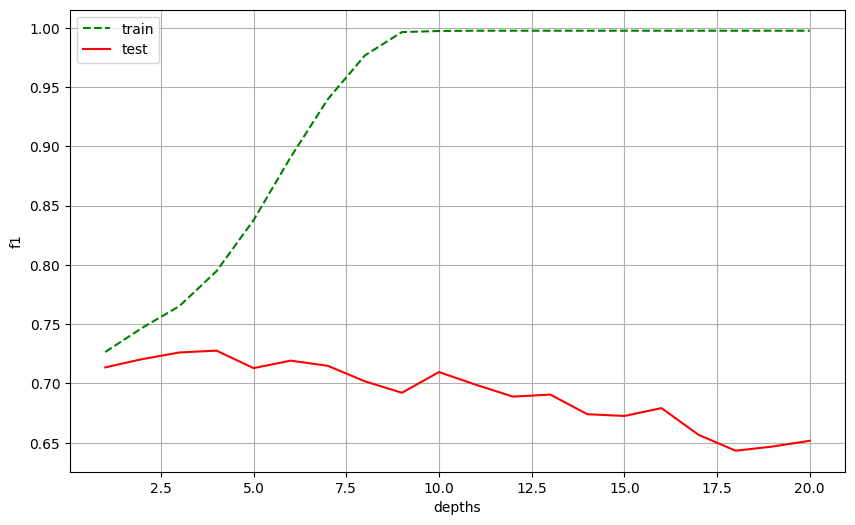

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(depths, f1_train, color='green', linestyle = '--')
plt.plot(depths, f1_test, color='red', linestyle = '-')
plt.xlabel('depths')
plt.ylabel('f1')
plt.legend(['train', 'test'])
plt.grid()
plt.show()

In [50]:
f1_train = []
f1_test = []
rates = np.arange(0.1, 1, 0.1)

for rate in rates:
  model = GradientBoostingClassifier(learning_rate=rate, random_state=1)
  model.fit(X_train, y_train)
  f1_train.append(f1_score(y_train, model.predict(X_train), average='macro'))
  f1_test.append(f1_score(y_test, model.predict(X_test), average='macro'))


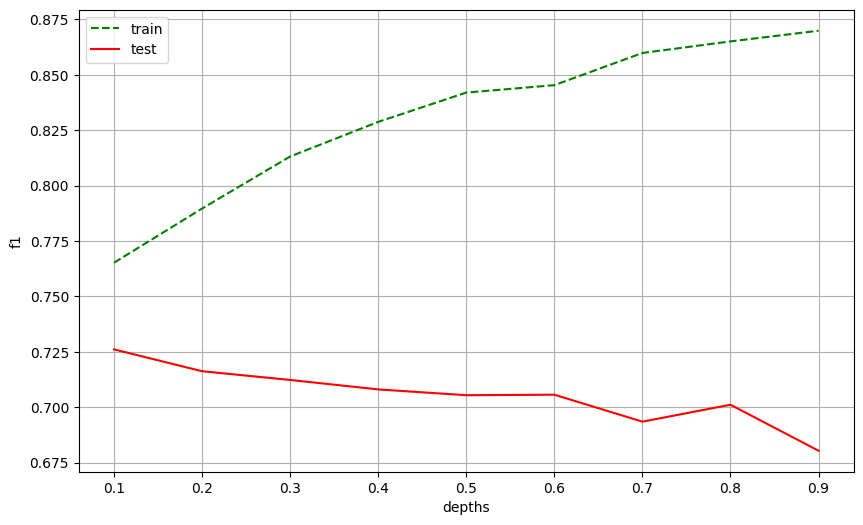

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(rates, f1_train, color='green', linestyle = '--')
plt.plot(rates, f1_test, color='red', linestyle = '-')
plt.xlabel('depths')
plt.ylabel('f1')
plt.legend(['train', 'test'])
plt.grid()
plt.show()

In [74]:
from sklearn.tree import DecisionTreeRegressor

class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_pred = None

    def fit(self, X, y):
        # Инициализация предсказаний как среднее значение целевой переменной
        self.base_pred = np.mean(y)
        y_hat = np.full_like(y, self.base_pred, dtype=float)
        residuals = y - y_hat

        for i in range(self.n_estimators):
            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=i
            )
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Получаем предсказание текущей моделью
            predictions = tree.predict(X)

            # Добавляем предсказание текущей модели в весь бустинг
            y_hat += self.learning_rate * predictions
            residuals = y - y_hat

    def predict(self, X):
        y_hat = np.full(X.shape[0], self.base_pred)
        for tree in self.trees:
            y_hat += self.learning_rate * tree.predict(X)
        return np.where(y_hat > 0.5, 1, 0)  # Бинарная классификация

In [75]:
model = GradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
f1_score(y_test, predictions, average='macro')

0.7272111900603142